<a href="https://colab.research.google.com/github/aadittambe/620_enterprise_story/blob/main/Nick_Aadit_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chicago crime data analysis (2001–2021)

We analyzed crime data from the Chicago Police Department reflecting incidents of crime that occurred in the City of Chicago from 2001 to 2021.

The data set has approximately 7.2 million rows and 22 columns, which makes it a great example of "big data." The data is provided by the Chicago Police Department and each row represents a reported crime.
The data set can be found [here](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2).

Analysis by Nick McMillan and Aadit Tambe

### Setup

In [ ]:
!apt-get update
# installing java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 https://cloud.r-project.org/bin/linux/ubuntu bi

Downloading Apache Spark from a repository, unzipping, and installing it


In [ ]:
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop2.7.tgz
!tar xf spark-3.0.0-bin-hadoop2.7.tgz
!pip install -q findspark

Setting up environment 

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop2.7"
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import  (StructType, 
                                StructField, 
                                DateType, 
                                BooleanType,
                                DoubleType,
                                IntegerType,
                                StringType,
                               TimestampType)

from pyspark.sql.functions import col,unix_timestamp
spark = SparkSession.builder.master("local[*]").getOrCreate()
import altair as alt
from IPython.display import display


In [ ]:
import pyspark.sql.functions as func
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## Load Data

Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load data

Create schema

In [ ]:
data_schema = StructType([StructField("ID", StringType(), True),
                            StructField("CaseNumber", StringType(), True),
                            StructField("Date", StringType(), True ),
                            StructField("Block", StringType(), True),
                            StructField("IUCR", StringType(), True),
                            StructField("PrimaryType", StringType(), True  ),
                            StructField("Description", StringType(), True ),
                            StructField("LocationDescription", StringType(), True ),
                            StructField("Arrest", BooleanType(), True),
                            StructField("Domestic", BooleanType(), True),
                            StructField("Beat", StringType(), True),
                            StructField("District", StringType(), True),
                            StructField("Ward", StringType(), True),
                            StructField("CommunityArea", StringType(), True),
                            StructField("FBICode", StringType(), True ),
                            StructField("XCoordinate", DoubleType(), True),
                            StructField("YCoordinate", DoubleType(), True ),
                            StructField("Year", IntegerType(), True),
                            StructField("UpdatedOn", DateType(), True ),
                            StructField("Latitude", DoubleType(), True),
                            StructField("Longitude", DoubleType(), True),
                            StructField("Location", StringType(), True )
                            ])

In [ ]:
#file_path_aadit = '/content/drive/MyDrive/Copy of chicago_crime_data_2001_present.csv'
#crime_data = spark.read.csv(file_path_aadit, header = True, schema = data_schema)


file_path_nick =  '/content/drive/MyDrive/Big Data Project/chicago_crime_data_2001_present.csv'
crime_data = spark.read.csv(file_path_nick, header = True, schema = data_schema)

## View & Clean Data

In [ ]:

crime_data.printSchema() #make sure schema loaded correctly
crime_data.show(n=10) #view first data


root
 |-- ID: string (nullable = true)
 |-- CaseNumber: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- PrimaryType: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- LocationDescription: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- CommunityArea: string (nullable = true)
 |-- FBICode: string (nullable = true)
 |-- XCoordinate: double (nullable = true)
 |-- YCoordinate: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- UpdatedOn: date (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)

+--------+----------+--------------------+--------------------+----+------------------+--------------------+-----

In [ ]:
print(f'There are {crime_data.count()} rows of data')

There are 7294643 rows of data


## Adding features to the data

In [ ]:
date_function =  udf(lambda x: datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p'), TimestampType())


#convert data from string to a time stamp
crime_data = crime_data.withColumn('Date_time', date_function(col('Date')))
# add week day feature
crime_data = crime_data.withColumn('week_day', func.date_format(col("Date_time"), "E"))
# add regular date feature, yyyy-mm-dd
crime_data = crime_data.withColumn("regular_date", to_date("Date_time"))

crime_data.printSchema() #make sure schema loaded correctly


root
 |-- ID: string (nullable = true)
 |-- CaseNumber: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- PrimaryType: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- LocationDescription: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- CommunityArea: string (nullable = true)
 |-- FBICode: string (nullable = true)
 |-- XCoordinate: double (nullable = true)
 |-- YCoordinate: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- UpdatedOn: date (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Date_time: timestamp (nullable = true)
 |-- week_day: string (nullable = true)
 |-- regular_date: date (nulla

## Analysis

What percent of crimes lead to an arrest?

In [ ]:
crime_data.select("Arrest").distinct().show() #show the full range of values for the Arrest column

+------+
|Arrest|
+------+
|  true|
| false|
+------+



In [ ]:
percent_arrests = crime_data.filter(col("Arrest") == 'true').count() / crime_data.select("Arrest").count()
print(f'{percent_arrests*100}% of crimes reported to Chicago PD lead to an arrest')

27.083409016726385% of crimes reported to Chicago PD lead to an arrest


How often has each crime resulted in an arrest?

In [ ]:
import pyspark.sql.functions as func

import altair as alt
from vega_datasets import data
crime_data.groupBy("PrimaryType")\
 .agg(func.count(func.lit(1)).alias("TypeCrime"))\
 .sort(func.desc("TypeCrime"))\
 .show(n=40, truncate= False)

+---------------------------------+---------+
|PrimaryType                      |TypeCrime|
+---------------------------------+---------+
|THEFT                            |1536728  |
|BATTERY                          |1335864  |
|CRIMINAL DAMAGE                  |830450   |
|NARCOTICS                        |736888   |
|ASSAULT                          |463107   |
|OTHER OFFENSE                    |452650   |
|BURGLARY                         |408950   |
|MOTOR VEHICLE THEFT              |336243   |
|DECEPTIVE PRACTICE               |309267   |
|ROBBERY                          |274228   |
|CRIMINAL TRESPASS                |205824   |
|WEAPONS VIOLATION                |87645    |
|PROSTITUTION                     |69388    |
|PUBLIC PEACE VIOLATION           |50866    |
|OFFENSE INVOLVING CHILDREN       |50847    |
|CRIM SEXUAL ASSAULT              |27945    |
|SEX OFFENSE                      |27923    |
|INTERFERENCE WITH PUBLIC OFFICER |17566    |
|GAMBLING                         

In [ ]:
# group crime data by year, crime type and arrest
crime_arrest = crime_data.groupBy("Year", "PrimaryType", "Arrest" )\
 .agg(func.count(func.lit(1)).alias("NumCrime")).toPandas()
#crime_arrest

# pivot to rearrange the dataframe
crime_arrest_pivot = crime_arrest.pivot(index = ["PrimaryType", "Year"], columns = "Arrest", values= "NumCrime")

crime_arrest_pivot


Arrest                   False   True 
PrimaryType       Year                
ARSON             2001   829.0   181.0
                  2002   876.0   156.0
                  2003   815.0   140.0
                  2004   669.0   109.0
                  2005   570.0   121.0
...                        ...     ...
WEAPONS VIOLATION 2017  1009.0  3677.0
                  2018  1653.0  3803.0
                  2019  2114.0  4225.0
                  2020  2985.0  5439.0
                  2021   492.0  1005.0

[656 rows x 2 columns]

In [ ]:
# Get arrest_percentage
crime_arrest_pivot["arrest_percentage"] = (crime_arrest_pivot[True]/(crime_arrest_pivot[False]+ crime_arrest_pivot[True]))*100

crime_arrest_pivot


Arrest                   False    True  arrest_percentage
PrimaryType       Year                                   
ARSON             2001   829.0   181.0          17.920792
                  2002   876.0   156.0          15.116279
                  2003   815.0   140.0          14.659686
                  2004   669.0   109.0          14.010283
                  2005   570.0   121.0          17.510854
...                        ...     ...                ...
WEAPONS VIOLATION 2017  1009.0  3677.0          78.467776
                  2018  1653.0  3803.0          69.703079
                  2019  2114.0  4225.0          66.650891
                  2020  2985.0  5439.0          64.565527
                  2021   492.0  1005.0          67.134269

[656 rows x 3 columns]

In [ ]:
# group by year, crime type and arrest
year_crime = crime_data.groupBy("Year", "PrimaryType", "Arrest" )\
 .agg(func.count(func.lit(1)).alias("NumCrime")).toPandas()
#crime_arrest

# rearrange column heads
year_crime_pivot = year_crime.pivot(index = ["Year", "PrimaryType"], columns = "Arrest", values= "NumCrime")
#year_crime_pivot

year_crime_pivot["arrest_percentage"] = (year_crime_pivot[True]/(year_crime_pivot[False]+ year_crime_pivot[True]))*100

#year_crime_pivot


year_crime_pivot.reset_index(inplace=True)
year_crime_pivot.loc[year_crime_pivot.Year=='2019']

# convert columns to strings
year_crime_pivot.columns = year_crime_pivot.columns.astype(str)

# year_crime_pivot

#### Visualize findings by year

In [ ]:
# first, create a list with all the years, we'll use this to loop through
year_test = year_crime_pivot['Year'].to_list()

yearList = []
for i in year_test:
    if i not in yearList:
        yearList.append(i)
#yearList

# loop through the year list to create charts for each year
for year in yearList:
  chart = alt.Chart(year_crime_pivot.loc[year_crime_pivot.Year==year]).mark_bar().encode(
    x='PrimaryType',
    y='arrest_percentage',
  ).properties(
    title = str(year),
)
  chart.display()

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

#### Visualize findings by crime type

In [ ]:
# create a list with all the crime types
crime_test = year_crime_pivot['PrimaryType'].to_list()

crimeList = []
for crime in crime_test:
  if crime not in crimeList:
    crimeList.append(crime)

#loop through crime list to create charts 
for crime in crimeList:
  chart = alt.Chart(year_crime_pivot.loc[year_crime_pivot.PrimaryType==crime]).mark_bar().encode(
    x='Year',
    y='arrest_percentage',
  ).properties(
    title = str(crime),
)
  chart.display()

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

### Prediction 

In [ ]:
from fbprophet import Prophet

In [ ]:
# aggregate crimes based on day
day_crime = crime_data.groupby("regular_date").agg(func.count(func.lit(1)).alias("NumCrime"))
day_crime.show()
#convert smaller dataset to pandas now
day_crime.pd = day_crime.toPandas()
#rename columns to use prophet library on 
day_crime.pd_clean = day_crime.pd.rename(columns = {"regular_date": "ds", "NumCrime": "y"})
#convert ds to a date type
day_crime.pd_clean["ds"] = pd.to_datetime(day_crime.pd_clean["ds"])


+------------+--------+
|regular_date|NumCrime|
+------------+--------+
|  2016-03-01|     817|
|  2015-05-19|     707|
|  2014-11-12|     595|
|  2018-08-10|     857|
|  2007-11-15|    1127|
|  2013-09-09|     868|
|  2015-03-09|     726|
|  2017-09-11|     691|
|  2019-05-08|     759|
|  2018-05-28|     888|
|  2019-06-04|     771|
|  2017-08-11|     765|
|  2002-03-02|    1092|
|  2002-06-20|    1397|
|  2001-05-16|    1381|
|  2009-07-25|    1136|
|  2002-12-06|    1282|
|  2013-05-21|     931|
|  2007-04-20|    1402|
|  2002-12-25|     803|
+------------+--------+
only showing top 20 rows



In [ ]:
# training data will be from 2001 - 2018
crime_dates_2001_2018 = day_crime.pd_clean[(day_crime.pd_clean['ds']>='2001-01-01')&(day_crime.pd_clean['ds']<='2018-12-31')]

In [ ]:
crime_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()


,ds,yhat,yhat_lower,yhat_upper
0,2001-01-01,1210.759232,1035.404905,1381.357950
1,2001-01-02,1228.809667,1058.524969,1396.609557
2,2001-01-03,1237.694887,1070.938661,1420.736057
3,2001-01-04,1229.904261,1053.342594,1414.229644
4,2001-01-05,1288.708350,1111.696140,1456.712496


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1440x432 with 0 Axes>

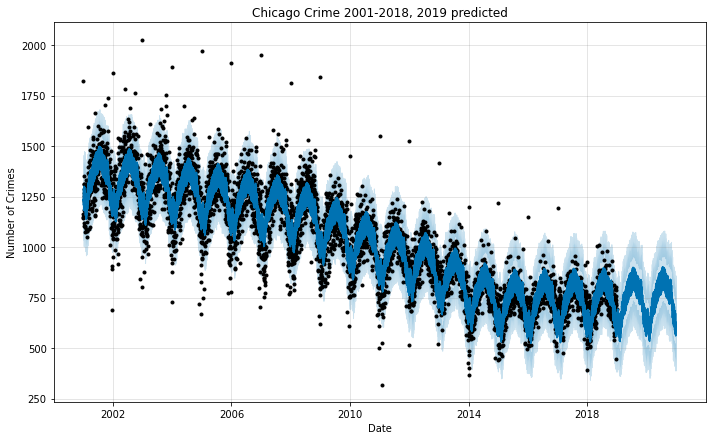

In [ ]:
# create model with fb prophet
crime_model = Prophet(interval_width=0.95)
crime_model.fit(crime_dates_2001_2018)

crime_forecast = crime_model.make_future_dataframe(periods=730, freq='D') #show two years prediction, by day
crime_forecast = crime_model.predict(crime_forecast)
plt.figure(figsize=(20, 6))
crime_model.plot(crime_forecast, xlabel = 'Date', ylabel = 'Number of Crimes')
plt.title('Chicago Crime 2001-2018, 2019 predicted');


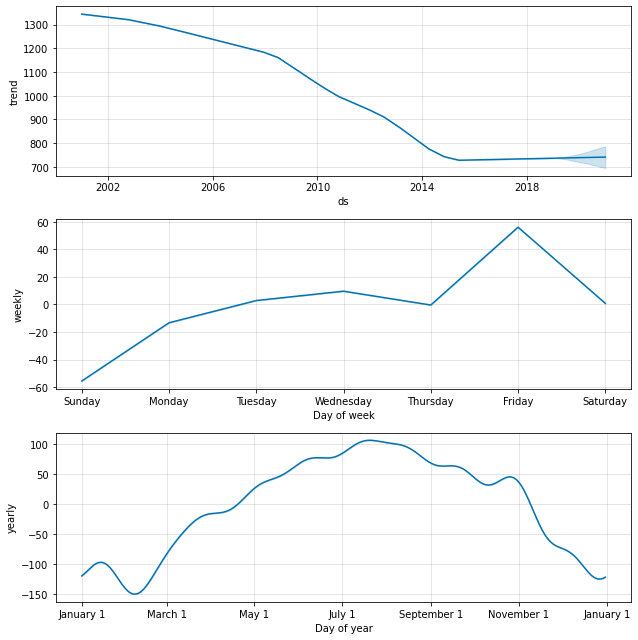

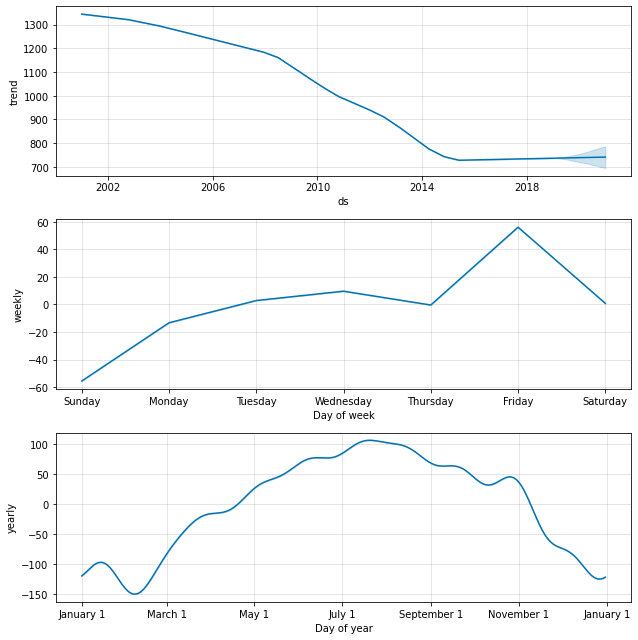

In [ ]:
crime_model.plot_components(crime_forecast) #this prints out the components of the models

In [ ]:
# show the forcecasted table
crime_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2001-01-01,1344.303657,1035.404905,1381.357950,1344.303657,1344.303657,-133.544425,-133.544425,-133.544425,-13.306211,-13.306211,-13.306211,-120.238214,-120.238214,-120.238214,0.0,0.0,0.0,1210.759232
1,2001-01-02,1344.268314,1058.524969,1396.609557,1344.268314,1344.268314,-115.458647,-115.458647,-115.458647,2.830939,2.830939,2.830939,-118.289585,-118.289585,-118.289585,0.0,0.0,0.0,1228.809667
2,2001-01-03,1344.232970,1070.938661,1420.736057,1344.232970,1344.232970,-106.538083,-106.538083,-106.538083,9.610429,9.610429,9.610429,-116.148512,-116.148512,-116.148512,0.0,0.0,0.0,1237.694887
3,2001-01-04,1344.197627,1053.342594,1414.229644,1344.197627,1344.197627,-114.293366,-114.293366,-114.293366,-0.419348,-0.419348,-0.419348,-113.874018,-113.874018,-113.874018,0.0,0.0,0.0,1229.904261
4,2001-01-05,1344.162283,1111.696140,1456.712496,1344.162283,1344.162283,-55.453933,-55.453933,-55.453933,56.074885,56.074885,56.074885,-111.528819,-111.528819,-111.528819,0.0,0.0,0.0,1288.708350


In [ ]:
# add up all the predicted crime numbers for 2019
predicted_2019 = crime_forecast[(crime_forecast['ds']>='2019-01-01')&(crime_forecast['ds']<='2019-12-30')]['yhat'].sum()
print(f'Predicted Crime for 2019: {predicted_2019}')

#add up the actual crime numbers for 2019
actual_2019 = day_crime.pd_clean[(day_crime.pd_clean['ds']>='2019-01-01')&(day_crime.pd_clean['ds']<='2019-12-30')]["y"].sum()
print(f'Actual Crime for 2019: {actual_2019}')

Predicted Crime for 2019: 268782.26627251954
Actual Crime for 2019: 260051


In [ ]:
# evaluate daily crime numbers
df_2019_yhat = crime_forecast[(crime_forecast['ds']>='2019-01-01')&(crime_forecast['ds']<='2019-12-30')][["ds", "yhat"]]
print(len(df_2019_yhat))

df_2019_actual = day_crime.pd_clean[(day_crime.pd_clean['ds']>='2019-01-01')&(day_crime.pd_clean['ds']<='2019-12-30')]
print(len(df_2019_actual))


#merge dataframes
metric_df = pd.merge(df_2019_actual, df_2019_yhat, on = "ds")
metric_df.set_index('ds')
metric_df.head()




364
364


,ds,y,yhat
0,2019-05-08,759,783.167915
1,2019-06-04,771,811.411649
2,2019-09-22,657,743.328000
3,2019-11-01,839,832.083115
4,2019-11-18,683,680.090678


In [ ]:
#evaluate results

r2_score(metric_df.y, metric_df.yhat)
mean_squared_error(metric_df.y, metric_df.yhat)
mean_absolute_error(metric_df.y, metric_df.yhat)

59.06848633008406